In [1]:
import os
import sys
# Go up one level from the notebooks directory to reach project root
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
sys.path.insert(0, project_root)  # Insert at beginning of path to take precedence

import math
import numpy as np
import matplotlib.pyplot as plt 

from mssfp.simulations import ssfp
from mssfp.phantoms import shepp_logan, simple
from mssfp.recons import gs_recon

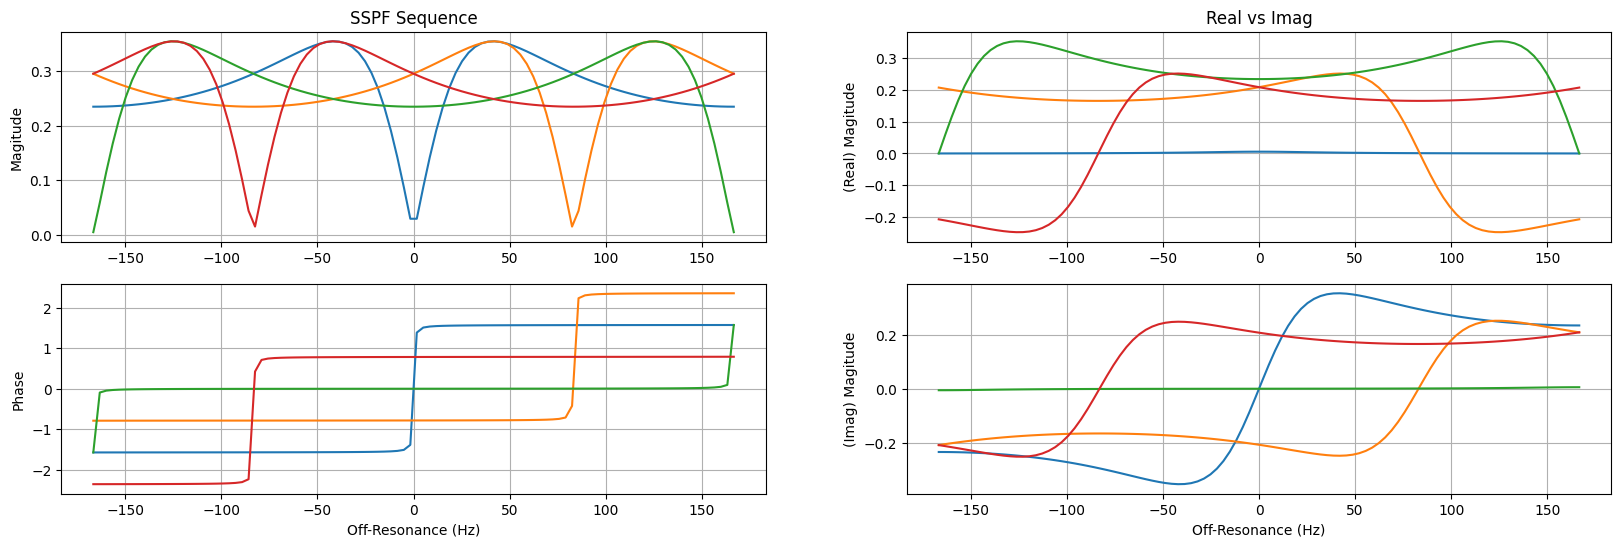

In [2]:
def ssfp_1d_example():
    npcs = 4
    T1, T2 = 1, .5
    TR, alpha = 3e-3, np.deg2rad(30)
    TE = TR / 2.0
    BetaMax = np.pi
    beta = np.linspace(-BetaMax, BetaMax, 100)
    f = beta / TR / (2 * np.pi)
    pcs = np.linspace(0, 2 * math.pi, npcs, endpoint=False)
    M = ssfp(T1, T2, TR, TE, alpha, f0=f, dphi=pcs)

    plt.figure(figsize=(20,6))
    plt.subplot(221)
    plt.plot(f, np.absolute(M))
    plt.ylabel('Magitude')
    plt.title('SSPF Sequence')
    plt.grid(True)

    plt.subplot(223)
    plt.plot(f, np.angle(M))
    plt.xlabel('Off-Resonance (Hz)')
    plt.ylabel('Phase')
    plt.grid(True)

    plt.subplot(222)
    plt.plot(f, M.real)
    plt.title('Real vs Imag')
    plt.ylabel('(Real) Magitude')

    plt.grid(True)

    plt.subplot(224)
    plt.plot(f, M.imag)
    plt.ylabel('(Imag) Magitude')
    plt.xlabel('Off-Resonance (Hz)')
    plt.grid(True)
    plt.show()

ssfp_1d_example()

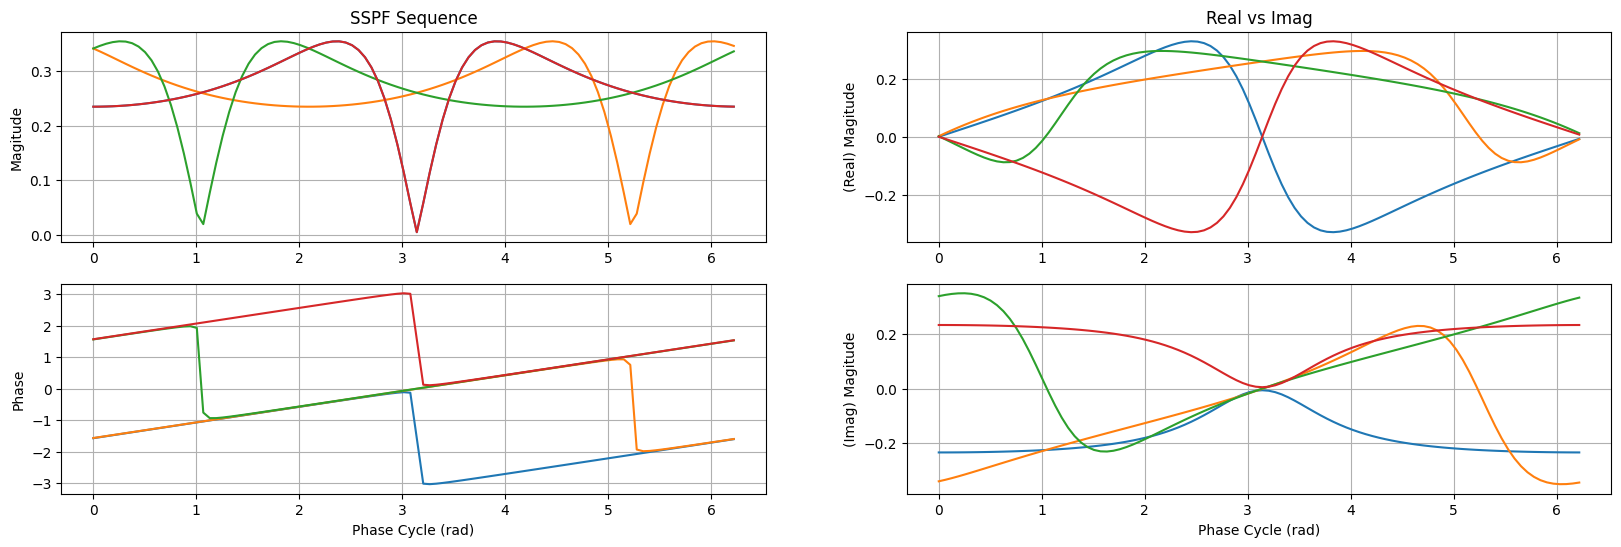

In [3]:
def ssfp_1d_example():
    npcs = 100
    T1, T2 = 1, .5
    TR, alpha = 3e-3, np.deg2rad(30)
    TE = TR / 2.0
    BetaMax = np.pi
    beta = np.linspace(-BetaMax, BetaMax, 4)
    f = beta / TR / (2 * np.pi)
    pcs = np.linspace(0, 2 * math.pi, npcs, endpoint=False)
    M = ssfp(T1, T2, TR, TE, alpha, f0=f, dphi=pcs).T
    
    plt.figure(figsize=(20,6))
    plt.subplot(221)
    plt.plot(pcs, np.absolute(M))
    plt.ylabel('Magitude')
    plt.title('SSPF Sequence')
    plt.grid(True)

    plt.subplot(223)
    plt.plot(pcs, np.angle(M))
    plt.xlabel('Phase Cycle (rad)')
    plt.ylabel('Phase')
    plt.grid(True)

    plt.subplot(222)
    plt.plot(pcs, M.real)
    plt.title('Real vs Imag')
    plt.ylabel('(Real) Magitude')

    plt.grid(True)

    plt.subplot(224)
    plt.plot(pcs, M.imag)
    plt.ylabel('(Imag) Magitude')
    plt.xlabel('Phase Cycle (rad)')
    plt.grid(True)
    plt.show()

ssfp_1d_example()

(100,)


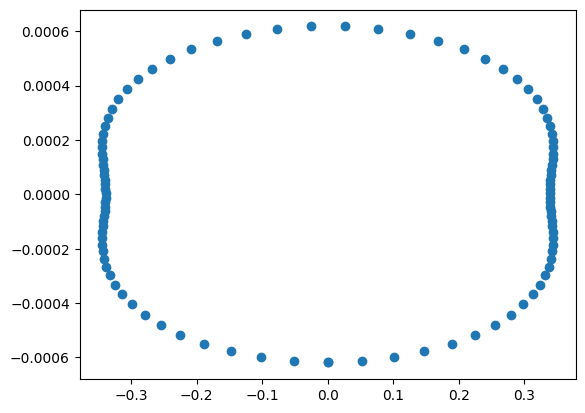

In [12]:
def ssfp_complex_example():
    npcs = 4
    T1, T2 = 4.2, 1.99
    TR, alpha = 3e-3, np.deg2rad(60)
    TE = TR / 2.0
    BetaMax = 2 * np.pi
    beta = np.linspace(-BetaMax, BetaMax, 100)
    f = beta / TR / (2 * np.pi)
    pcs = np.linspace(0, 2 * math.pi, npcs, endpoint=False)
    M = ssfp(T1, T2, TR, TE, alpha, f0=f, dphi=pcs)[:,0]
    print(M.shape)

    plt.scatter(M.imag, M.real)
    plt.show()

ssfp_complex_example()

(100, 9)


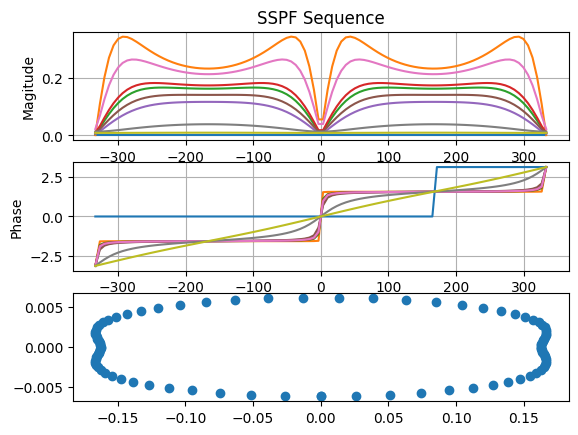

In [20]:
def ssfp_1d_example2():
    TR, alpha = 3e-3, np.deg2rad(30)
    TE = TR / 2.0
    BetaMax = 2 * np.pi
    beta = np.linspace(-BetaMax, BetaMax, 100)
    f = beta / TR / (2 * np.pi)

    keys = list(simple.tissue_parameters.keys())
    M = []
    for key in keys:
        if key == 'none':
            continue
        T1 = simple.tissue_parameters[key][1]
        T2 = simple.tissue_parameters[key][2]
        M.append(ssfp(T1, T2, TR, TE, alpha, f0=f))
    M = np.squeeze(np.array(M))
    M = np.transpose(M, (1,0))
    print(M.shape)

    plt.subplot(311)
    plt.plot(f, np.absolute(M))
    plt.ylabel('Magitude')
    plt.title('SSPF Sequence')
    plt.grid(True)

    plt.subplot(312)
    plt.plot(f, np.angle(M))
    plt.xlabel('Off-Resonance (Hz)')
    plt.ylabel('Phase')
    plt.grid(True)

    plt.subplot(313)
    plt.scatter(M.imag[:, 2], M.real[:,2])
    plt.show()
    
ssfp_1d_example2()

c:\Users\mmend\projects\mri\ssfp\mssfp\simulations\ssfp.py:64: RuntimeWarning: overflow encountered in exp
  E1 = np.where(T1 > 0, np.exp(-TR / T1), 0)
c:\Users\mmend\projects\mri\ssfp\mssfp\simulations\ssfp.py:65: RuntimeWarning: overflow encountered in exp
  E2 = np.where(T2 > 0, np.exp(-TR / T2), 0)
c:\Users\mmend\projects\mri\ssfp\mssfp\simulations\ssfp.py:91: RuntimeWarning: overflow encountered in exp
  T2_decay = np.where(T2 > 0, np.exp(-TE / T2), 0)


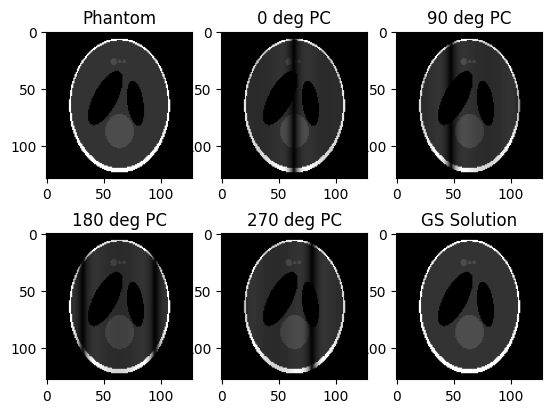

In [6]:
def ssfp_2d_example():
    N = 128
    M0 = shepp_logan.generate_shepp_logan(N)

    T1, T2 = M0*2, M0/2
    TR, alpha = 3e-3, np.deg2rad(30)
    TE = TR / 2.0
    pcs = np.linspace(0, 2*np.pi, 4, endpoint=False)
    df, _ = np.meshgrid(
        np.linspace(-1/TR, 1/TR, N),
        np.linspace(-1/TR, 1/TR, N))

    data = ssfp(T1, T2, TR, TE, alpha, field_map=df, dphi=pcs, M0=M0)

    # Show Phantom 
    ny, nx = 3, 2
    plt.figure()
    plt.subplot(nx, ny, 1)
    plt.imshow(M0, cmap='gray')
    plt.title('Phantom')

    # Show the phase-cycled images
    for ii in range(4):
        plt.subplot(nx, ny, ii+2)
        plt.imshow(np.abs(data[..., ii]), cmap='gray')
        plt.title('%d deg PC' % (ii*90))

    # Show the recon
    recon = gs_recon(data, pc_axis=2)
    plt.subplot(nx, ny, 6)
    plt.imshow(np.abs(recon), cmap='gray')
    plt.title('GS Solution')
    plt.show()

    return data
    
data = ssfp_2d_example()